# Assign networks to parcels

In [31]:
import pandas as pd
import nibabel as nib
import numpy as np

parceldir = '/data/perlman/moochie/user_data/CamachoCat/combinedDWI/template/'
parcels = pd.read_csv(parceldir + 'MMP_subcort.csv', index_col='region_num')
ac_data = nib.load(parceldir+'ColeAnticevic_32k_fs_LR.dlabel.nii').get_fdata()
mmp_data = nib.load(parceldir + 'Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii').get_fdata()

for p in parcels.index:
    parcnet = ac_data[mmp_data==p]
    majnet, count = np.unique(parcnet, return_counts=True)
    if len(majnet>0):
        parcels.loc[p,'net2num']=majnet[0]
    else:
        parcels.loc[p,'net2num']=0

parcels.to_csv(parceldir + 'MMP_subcortrev.csv')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# Perform Network Analysis

In [32]:
from nipype.pipeline.engine import Workflow, Node, JoinNode, MapNode
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from glob import glob

# MATLAB setup - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/spm12/toolbox')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# FSL set up- change default file output type
from nipype.interfaces.fsl import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# Study-specific variables
project_home = '/data/perlman/moochie/user_data/CamachoCat'
output_dir = project_home + '/combinedDWI/network_analysis'
workflow_dir = project_home + '/combinedDWI/workflows'
chec_dir = project_home + '/ChEC/dmri_proc/proc/preprocessing/dsi_studio'
emogrow_dir = project_home + '/EmoGrow/dMRI_proc/proc/preprocessing/dsi_studio'

atlas = '/usr/local/pkg/dsistudio/atlas/MMP_subcort.nii.gz'
atlas_key = project_home + '/combinedDWI/template/MMP_subcortrev.csv'
stress_data = project_home + '/combinedDWI/stress_data/dwi_sample_LEQ_summary_scores_20201116.csv'

### Collect all the connectivity map files

In [33]:
chec_files = glob(chec_dir + '/*/*.connectogram.txt')
emogrow_files = glob(emogrow_dir + '/*/*.connectogram.txt')

connect_files = chec_files + emogrow_files
len(connect_files)

96

### Compute subject level network measures and aggregate them together

In [34]:
# Sink data of interest 
substitutions = [('_connectogram_..data..perlman..moochie..user_data..CamachoCat..EmoGrow..dMRI_proc..proc..preprocessing..dsi_studio..', ''),
                 ('..dmri_unwarped.nii.gz.src.gz.odf6.f5rec.bal.csfc.012fy.rdi.gqi.1.15.fib.gz.MMP_subcort.qa.pass.connectogram.txt',''),
                 ('_connectogram_..data..perlman..moochie..user_data..CamachoCat..ChEC..dmri_proc..proc..preprocessing..dsi_studio..',''),
                 ('..dmri_unwarped.nii.gz.src.gz.odf6.f5rec.bal.csfc.012fy.rdi.gqi.1.15.fib.gz.MMP_subcort.qa.pass.connectogram.txt',''),
                 ('_dMRI_98dir_unwarped.src.odf6.f5rec.bal.csfc.012fy.rdi.gqi.1.15.fib.gz.MMP_subcort.qa.pass.connectogram.txt','')]
datasink = Node(DataSink(base_directory = output_dir,
                         substitutions = substitutions,
                         container = output_dir), 
                name='datasink')

In [35]:
def net_connect(connectogram, atlas_info,threshold):
    '''This function takes a connectgram and an atlas with assigned networks and creates
    a connectogram of the network-wide connectivity.

    Inputs:
        connectogram:  the subject's connectogram data.
        atlas_info:  parcellation-network mapping
        threshold:  None or number. NaNs values below this threshold.

    Outputs:
        network_connect: network connectogram  
    '''
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    import numpy as np
    import pandas as pd

    labels_df = pd.read_csv(atlas_info,index_col=0)
    labels_df = labels_df.loc[:,['network','region']]

    t =  pd.read_csv(connectogram,index_col=1,header=1,skiprows=0, sep='\t')
    t = t.drop(columns=['data','Unnamed: 386'])
    t = t.reindex(labels_df['region'].tolist(),columns=labels_df['region'].tolist())
    t.columns = pd.MultiIndex.from_frame(labels_df, names=['network','region'])
    t.index = pd.MultiIndex.from_frame(labels_df, names=['network','region'])
    if np.isfinite(threshold):
        t[t==threshold]= np.nan
    t = t.groupby(level=0).mean()
    t = t.groupby(level=0, axis=1).mean()
    t = t.drop(labels=['none'], axis=0)
    t = t.drop(labels=['none'], axis=1)
    t.to_csv('network_connectogram.csv')
    network_connect = abspath('network_connectogram.csv')
    return(network_connect)

def combine_sample_connect(sub_net_conn_files):
    '''This function takes a list of subject-level adjacency matrices and compiles
    them to a single csv.

    Inputs:
        sub_net_conn_files:  list of subject file names (each a pandas dataframe csv)

    Outputs:
        sample_connect: sample aggregate of connectivity values 
    '''
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath, dirname,split
    import pandas as pd
    import numpy as np

    
    temp = pd.read_csv(sub_net_conn_files[0], index_col=0)
    regions = temp.columns.to_list()
    col_names = []
    k=0
    while k<len(regions):
        for b in range(k+1,len(regions)):
            col_names.append('{0}_{1}'.format(regions[k].replace('_',''),regions[b].replace('_','')))
        k=k+1
    sample_connect_df = DataFrame(columns = col_names)
    
    for file in sub_net_conn_files:
        sub = file.split('dsi_studio..',1)[1][:,5]
        temp = pd.read_csv(file, index_col=0)
        k=0
        while k < len(regions):
            for b in range(k+1,len(regions)):
                sample_connect_df.loc[sub,'{0}_{1}'.format(regions[k].replace('_',''),
                                                          regions[b].replace('_',''))]=temp.loc[regions[k],regions[b]]
            k=k+1 
    
    sample_connect.to_csv('full_sample_connectivity.csv')
    sample_connect = abspath('full_sample_connectivity.csv')
    return(sample_connect)

In [36]:
make_network_matrix = Node(Function(input_names=['connectogram', 'atlas_info', 'threshold'], 
                                    output_names=['network_connect'],
                                    function=net_connect), 
                           name='make_network_matrix')
make_network_matrix.inputs.atlas_info = atlas_key
make_network_matrix.inputs.threshold = 0
make_network_matrix.iterables=[('connectogram',connect_files)]

combine_sample_conn = JoinNode(Function(input_names=['sub_net_conn_files'], 
                                        output_names=['sample_connect'],
                                        function=combine_sample_connect), 
                               name='combine_sample_conn', 
                               joinfiled='sub_net_conn_files',
                               joinsource='make_network_matrix')

In [ ]:
connect_flow = Workflow(name='connect_flow')
connect_flow.connect([(make_network_matrix, datasink, [('network_connect','subject_network_connect')])
                     ])

connect_flow.base_dir = workflow_dir
connect_flow.run('MultiProc', plugin_args={'n_procs': 4, 'memory_gb':30})

In [39]:
from glob import glob
import pandas as pd

sub_net_conn_files = glob('/data/perlman/moochie/user_data/CamachoCat/combinedDWI/workflows/connect_flow/*/make_network_matrix/network_connectogram.csv')
sub_net_conn_files = sorted(sub_net_conn_files)
temp = pd.read_csv(sub_net_conn_files[0], index_col=0)
regions = temp.columns.to_list()
col_names = []
k=0
while k<len(regions):
    for b in range(k,len(regions)):
        col_names.append('{0}_{1}'.format(regions[k].replace('_',''),regions[b].replace('_','')))
    k=k+1
sample_connect_df = pd.DataFrame(columns = col_names)

for file in sub_net_conn_files:
    sub = file.split('dsi_studio..',1)[1][:4]
    temp = pd.read_csv(file, index_col=0)
    k=0
    while k < len(regions):
        for b in range(k,len(regions)):
            sample_connect_df.loc[sub,'{0}_{1}'.format(regions[k].replace('_',''),
                                                      regions[b].replace('_',''))]=temp.loc[regions[k],regions[b]]
        k=k+1 

sample_connect_df.to_csv(output_dir +'/full_sample_connectivity.csv')

In [ ]:
### Elastic-net model ###

from os.path import abspath
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
from scipy.stats import linregress, spearmanr
from sklearn.metrics import mean_squared_error, r2_score
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='white')
today = date.today()

out_dir = project_home + '/combinedDWI/network_analysis/ENET_results_10f/'
#load stress data
stress_data='/data/perlman/moochie/user_data/ChinJenna/StressNeurodev/scored_data/LEQCombined_scored_dwi_sample_5andup_20210416.csv'
labels_df = pd.read_csv(stress_data,index_col=0).sort_values(by='ID', axis=0)

#load connectivity data
X = pd.read_csv(out_dir+'full_sample_connectivity.csv', index_col=0).sort_values(by='ID', axis=0)

conditions = ['LEQ_tot_neg','LEQ_wprox_tot_neg']
tf = PowerTransformer()

for condition in conditions:
    labels_df[condition + '_yj'] = tf.fit_transform(labels_df[condition].to_numpy().reshape(-1,1))
    predcon = LinearRegression().fit(X=labels_df[['scan_age','male']],y=labels_df[condition + '_yj'])
    predcon = predcon.predict(labels_df[['scan_age','male']])
    labels_df[condition+'_res_yj'] = labels_df[condition + '_yj'] - predcon
    results_file = open(out_dir+'results_{0}_{1}.txt'.format(condition,today.strftime('%Y%m%d')),'w')
    
    y = condition + '_res_yj'
    enet = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], fit_intercept=True, cv=10, n_jobs=10, 
                        random_state=42).fit(X,labels_df[y])
    y_pred = enet.predict(X)

    # save the labels_df with the new y_pred data
    labels_df['{0}_predicted'.format(condition)] = y_pred
    
    ## Calculate measures of model fit
    # Use linear regression to estimate linear association between predicted and actual labels
    slope, intercept, r_val, p_val, stderr = linregress(labels_df[y], labels_df['{0}_predicted'.format(condition)])
    # Compute mean square error
    mse = mean_squared_error(labels_df[y], labels_df['{0}_predicted'.format(condition)])
    # Compute spearman (nonparametric) correlation
    spear_r, spear_p = spearmanr(labels_df[y], labels_df['{0}_predicted'.format(condition)])
    # Compute r^2 for pred versus actual
    r2 = r2_score(labels_df[y], labels_df['{0}_predicted'.format(condition)])
    # Write results to the results text files
    results_file.write('linear beta={0}, p={1}, MSE:{2} \n'.format(round(r_val,3), round(p_val,3), round(mse,3)))
    results_file.write('Spearman r={0}, p={1}\n'.format(round(spear_r,3), round(spear_p,3)))
    results_file.write('r^2 of pred/actual fit: {0}\n'.format(round(r2, 3)))
    results_file.close()

    # save weights
    np.save(out_dir+'weights{0}.npy'.format(condition),enet.coef_)
    svr_results_file = abspath(out_dir+'weights.npy')
    weights_df = pd.DataFrame(0, index=[0],columns=X.columns)

    weights_df.iloc[0,:]=enet.coef_
    weights_df.to_csv(out_dir+'weights_df_{0}_{1}.csv'.format(condition,today.strftime('%Y%m%d')))

    #plot predicted versus actual
    plt.scatter(labels_df[y], labels_df['{0}_predicted'.format(condition)])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.savefig(out_dir+'scatter_pred_actual_{0}_{1}.svg'.format(condition,today.strftime('%Y%m%d')))
    plt.close()
    
    # compute permuted importance scores
    result = permutation_importance(enet, X, labels_df[y], n_repeats=1000, random_state=42)
   
    # save importances data
    imp_df = pd.DataFrame(result.importances,index=X.columns,columns=['iter{0}'.format(x) for x in range(0,1000)])
    imp_df.to_csv(out_dir + 'importance_data_{0}_{1}.csv'.format(condition,today.strftime('%Y%m%d')))
   
    # sort the importances for plotting
    perm_sorted_idx = result.importances_mean.argsort()
    importance_sorted_idx = np.argsort(result.importances_mean)
    indices = np.arange(0, result.importances.shape[0]) + 0.5
   
    # plot the ranked importances
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.barh(indices,result.importances_mean[importance_sorted_idx], height=0.7)
    ax1.set_yticklabels(X.columns[importance_sorted_idx])
    ax1.set_yticks(indices)
    ax1.set_ylim((0, len(result.importances)))
    ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,labels=X.columns[perm_sorted_idx])
    ax1.set_title(y)
    ax2.set_title(y)
    fig.tight_layout()
    plt.savefig(out_dir + 'importance_ranks_{0}_{1}.svg'.format(condition,today.strftime('%Y%m%d')))
    plt.close()
    
labels_df.to_csv(out_dir+'labeling_results.csv')

In [68]:
def weights_to_adjmatrix(model_weights,sample_file):
    '''This function takes a list of subject-level adjacency matrices and compiles
    them to a single csv.

    Inputs:
        sub_net_conn_files:  list of subject file names (each a pandas dataframe csv)

    Outputs:
        sample_connect: sample aggregate of connectivity values 
    '''
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nilearn.plotting import plot_matrix
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import seaborn as sns
    
    sns.set(context='talk')
    
    weights = pd.read_csv(model_weights, index_col=0)
    sample_connect_df = pd.read_csv(sample_file, index_col=0)
    regions = sample_connect_df.columns.to_list()
    weights_adj_mat = pd.DataFrame(columns=sample_connect_df.columns,index=sample_connect_df.columns)
    
    for k in range(0,len(regions)):
        for b in range(0,len(regions)):
            if '{0}_{1}'.format(regions[k].replace('_',''),regions[b].replace('_','')) in weights.columns:
                weights_adj_mat.loc[regions[k],regions[b]] = weights.loc[weights.index[0],'{0}_{1}'.format(regions[k].replace('_',''),regions[b].replace('_',''))]
                weights_adj_mat.loc[regions[b],regions[k]] = weights.loc[weights.index[0],'{0}_{1}'.format(regions[k].replace('_',''),regions[b].replace('_',''))]
    
    weights_adj_mat.to_csv(model_weights[:-4]+'_adjmat.csv')
    weights_adj_mat[pd.isnull(weights_adj_mat)]=0
    weights_adj = weights_adj_mat.to_numpy()
    
    cmap = sns.diverging_palette(230,20,as_cmap=True)
    sns.heatmap(weights_adj_mat.astype(float),center=0, cmap=cmap)
    plt.savefig(model_weights[:-4]+'_adjmat.svg')
    plt.close()


sample_file='/data/perlman/moochie/user_data/CamachoCat/combinedDWI/network_analysis/subject_network_connect/1001/network_connectogram.csv'
weights=['weights_df_LEQ_tot_neg_{0}.csv'.format(today.strftime('%Y%m%d')),'weights_df_LEQ_wprox_tot_neg_{0}.csv'.format(today.strftime('%Y%m%d'))]
for w in weights:
    weights_to_adjmatrix(out_dir+w,sample_file)

<Figure size 432x288 with 0 Axes>

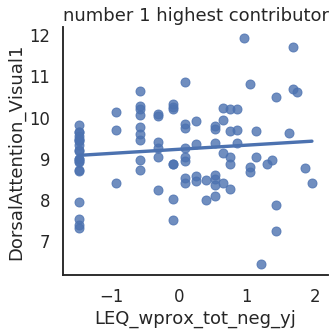

<Figure size 432x288 with 0 Axes>

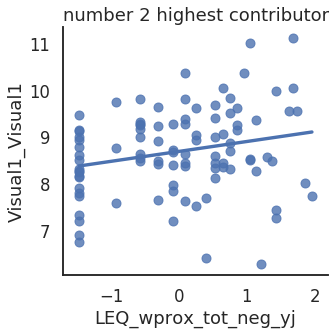

<Figure size 432x288 with 0 Axes>

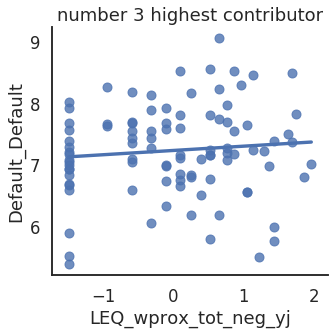

<Figure size 432x288 with 0 Axes>

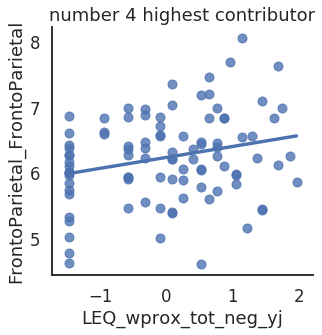

<Figure size 432x288 with 0 Axes>

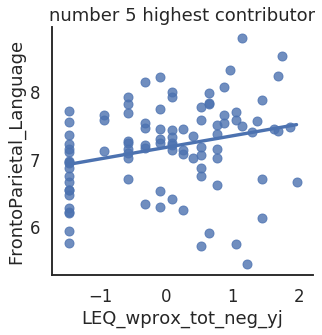

<Figure size 432x288 with 0 Axes>

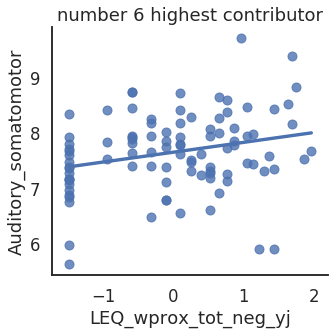

<Figure size 432x288 with 0 Axes>

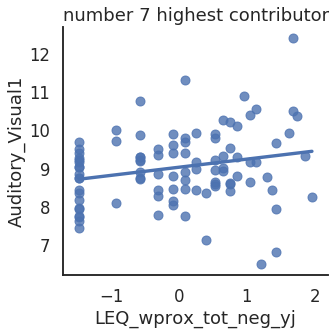

<Figure size 432x288 with 0 Axes>

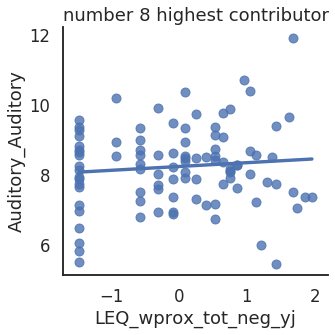

<Figure size 432x288 with 0 Axes>

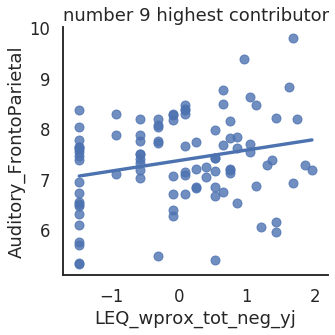

<Figure size 432x288 with 0 Axes>

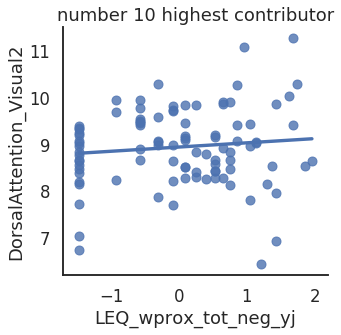

['DorsalAttention_Visual1', 'Visual1_Visual1', 'Default_Default', 'FrontoParietal_FrontoParietal', 'FrontoParietal_Language', 'Auditory_somatomotor', 'Auditory_Visual1', 'Auditory_Auditory', 'Auditory_FrontoParietal', 'DorsalAttention_Visual2']


In [70]:
## plot the associations found in the previous models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(context='talk', style='white')

out_dir = project_home+'/combinedDWI/network_analysis/ENET_results_10f/'
sample_data = pd.read_csv(out_dir + 'full_sample_connectivity.csv', index_col=None)
stress_data = pd.read_csv(out_dir + 'labeling_results.csv',index_col=0)
full_data = sample_data.merge(stress_data,on='ID')
conditions = ['LEQ_wprox_tot_neg']

for con in conditions:
    weights = pd.read_csv(out_dir + 'weights_df_{0}_{1}.csv'.format(con,today.strftime('%Y%m%d')))
    weights = weights.abs()
    top_weights = []
    i=1
    a=0
    while i==1:
        if (weights.max(axis=1)>0).any():
            top_weights.append(weights.idxmax(axis=1).to_list()[0]) #identify the highest weight
            plt.figure()
            sns.lmplot(x=con + '_yj',y=weights.idxmax(axis=1).to_list()[0],data=full_data, ci=None)
            plt.title('number {0} highest contributor'.format(a+1))
            plt.tight_layout()
            plt.savefig(out_dir+'{0}_feature{1}_lmplot.png'.format(con,a+1))
            plt.show()
            plt.close()
            weights = weights.drop(weights.idxmax(axis=1),axis=1)
            a=a+1
        else:
            i=0
    print(top_weights)

## Make figures for group level network information

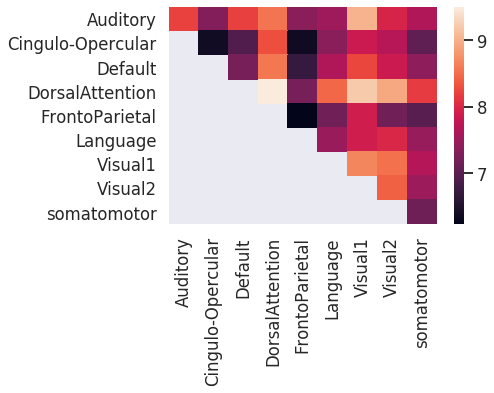

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='talk')
# make mean connectivity matrix (network level)
conn_data = pd.read_csv(out_dir+'full_sample_connectivity.csv', index_col=0)
mean_conn = conn_data.mean(axis=0).to_frame().T
mean_conn.to_csv('mean_conn.csv')
weights_to_adjmatrix('mean_conn.csv',sample_file)

adjmat = pd.read_csv(out_dir+'mean_conn_adjmat.csv',index_col=0)
sns.heatmap(adjmat)
#plt.tight_layout()
plt.savefig(out_dir + 'mean_conn_adjmat.svg')